# Sentence similarity with NLU using BERT embeddings
![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/nlu/blob/master/examples/colab/component_examples/sentence_embeddings/sentence_similarirty_stack_overflow_questions.ipynb)

## What will we cover?

## 1. How to get sentence Bert, USE, Electra sentence embeddings using BERT
## 2. How to find N most similar sentences in a dataset for a given sentence in the dataset using BERT
## 3. How to calculate the similarity matrix and visualize it for a dataset using  BERT
## 4. How to find the N most similar sentences in a datset for a **new sentence** that does not exist in the data using BERT
## 5. How to find the N most similar sentences in a dataset for a new sentence using BERT, USE, Electra at the same time!




# 0.1 Install NLU and Java

In [ ]:
!wget https://setup.johnsnowlabs.com/nlu/colab.sh -O - | bash
  

import nlu

--2022-04-15 03:21:05--  https://setup.johnsnowlabs.com/nlu/colab.sh
Resolving setup.johnsnowlabs.com (setup.johnsnowlabs.com)... 51.158.130.125
Connecting to setup.johnsnowlabs.com (setup.johnsnowlabs.com)|51.158.130.125|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://raw.githubusercontent.com/JohnSnowLabs/nlu/master/scripts/colab_setup.sh [following]
--2022-04-15 03:21:05--  https://raw.githubusercontent.com/JohnSnowLabs/nlu/master/scripts/colab_setup.sh
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1665 (1.6K) [text/plain]
Saving to: ‘STDOUT’

Installing  NLU 3.4.3rc2 with  PySpark 3.0.3 and Spark NLP 3.4.2 for Google Colab ...
-                   100%[===================>]   1.63K  --.-KB/s    in 0s   

# 0.2 Download sample dataset 60k Stack Overflow Questions with Quality Rating


https://www.kaggle.com/imoore/60k-stack-overflow-questions-with-quality-rate

In [ ]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Download the dataset 
! wget -N https://ckl-it.de/wp-content/uploads/2020/11/60kstackoverflow.csv -P /tmp
# Load dataset to Pandas
df = pd.read_csv('/tmp/60kstackoverflow.csv')
max_r = 5000
df = df.iloc[0:max_r]
df

--2022-04-15 03:22:58--  https://ckl-it.de/wp-content/uploads/2020/11/60kstackoverflow.csv
Resolving ckl-it.de (ckl-it.de)... 217.160.0.108, 2001:8d8:100f:f000::209
Connecting to ckl-it.de (ckl-it.de)|217.160.0.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 50356825 (48M) [text/csv]
Saving to: ‘/tmp/60kstackoverflow.csv’

60kstackoverflow.cs 100%[===================>]  48.02M  19.0MB/s    in 2.5s    

2022-04-15 03:23:02 (19.0 MB/s) - ‘/tmp/60kstackoverflow.csv’ saved [50356825/50356825]



,Id,Title,Body,Tags,CreationDate,Y
0,34552656,Java: Repeat Task Every Random Seconds,<p>I'm already familiar with repeating tasks e...,<java><repeat>,2016-01-01 00:21:59,LQ_CLOSE
1,34553034,Why are Java Optionals immutable?,<p>I'd like to understand why Java 8 Optionals...,<java><optional>,2016-01-01 02:03:20,HQ
2,34553174,Text Overlay Image with Darkened Opacity React...,<p>I am attempting to overlay a title over an ...,<javascript><image><overlay><react-native><opa...,2016-01-01 02:48:24,HQ
3,34553318,Why ternary operator in swift is so picky?,"<p>The question is very simple, but I just cou...",<swift><operators><whitespace><ternary-operato...,2016-01-01 03:30:17,HQ
4,34553755,hide/show fab with scale animation,<p>I'm using custom floatingactionmenu. I need...,<android><material-design><floating-action-but...,2016-01-01 05:21:48,HQ
...,...,...,...,...,...,...
4995,36742008,is it possible to use JavaScriptSpellCheck in ...,<p>I would like to perform Spell Checking on t...,<javascript><html><jsp>,2016-04-20 11:11:19,LQ_CLOSE
4996,36743857,"Map<String, Integer> foo - how do I get the va...",<p>I have a method:</p>\n\n<pre><code> public...,<java><dictionary><hashmap>,2016-04-20 12:29:50,LQ_CLOSE
4997,36744886,Facebook SDK iOS - User photos doesn't retriev...,<p>I am facing a weird bug with Facebook SDK. ...,<ios><objective-c><facebook><facebook-graph-ap...,2016-04-20 13:09:41,LQ_CLOSE
4998,36746382,Validate user input using seperate function,<p>How do I get this to not return 'brea outsi...,<python><python-3.x><python-3.5>,2016-04-20 14:07:03,LQ_CLOSE


# 1. Embed Sentences with Bert Sentence Embeddings  

We could either embed the Title or the question Body.

In [ ]:
pipe = nlu.load('embed_sentence.bert')
# pipe = nlu.load('en.embed_sentence.bert_large_cased') # if you have some time and RAM try a big BERT model!
predictions = pipe.predict(df.Title, output_level='document')
predictions

sent_small_bert_L2_128 download started this may take some time.
Approximate size to download 16.1 MB
[OK!]


,document,sentence_embedding_bert
0,Java: Repeat Task Every Random Seconds,"[-1.7254447937011719, -0.021515730768442154, 0..."
1,Why are Java Optionals immutable?,"[-0.8677306175231934, -0.1372649371623993, -0...."
2,Text Overlay Image with Darkened Opacity React...,"[-0.7461170554161072, -0.89825838804245, -0.27..."
3,Why ternary operator in swift is so picky?,"[-1.0729691982269287, 0.11187640577554703, -0...."
4,hide/show fab with scale animation,"[-0.5802487730979919, -0.2343166619539261, -0...."
...,...,...
4995,is it possible to use JavaScriptSpellCheck in ...,"[-0.2840780019760132, 0.913105309009552, 0.386..."
4996,"Map<String, Integer> foo - how do I get the va...","[-0.6755825281143188, 0.02196516841650009, 0.1..."
4997,Facebook SDK iOS - User photos doesn't retriev...,"[0.2970832586288452, 0.509556233882904, -0.359..."
4998,Validate user input using seperate function,"[-0.6373348236083984, 0.4810838997364044, -0.5..."


# 2.1 How to find N most similar sentences in a dataset for a given sentence in the dataset using BERT    
Sentences with small distances between their embeddings will be deemed as similar to each other. 

In [ ]:

## Calculate dinstance between all pairs of sentences in DF 
e_col = 'sentence_embedding_bert'

def get_sim_df_for_iloc(sent_iloc, predictions=predictions,e_col=e_col, pipe=pipe):
  # This function calculatse the distances for one sentences at  predictions[sent_iloc] to all other sentences in predictions using the embedding defined by e_col 
  # put embeddings in matrix
  embed_mat = np.array([x for x in predictions[e_col]])
  # calculate distance between every embedding pair
  sim_mat = cosine_similarity(embed_mat,embed_mat)
  print("Similarities for Sentence : " + df.iloc[sent_iloc].Title)
  # write sim scores to df
  df['sim_score'] = sim_mat[sent_iloc]
  return df 
sentence_to_compare=33
sim_df_for_one_sent = get_sim_df_for_iloc(sentence_to_compare,predictions,e_col)
sim_df_for_one_sent.sort_values('sim_score', ascending = False)

Similarities for Sentence : How to play gif in android from url?


,Id,Title,Body,Tags,CreationDate,Y,sim_score
33,34562879,How to play gif in android from url?,<p>I want to play animated gif from url in and...,<android><animated-gif>,2016-01-02 05:21:15,HQ,1.000000
3917,36146295,how to create a alert box in android alternati...,<p><strong>Create an alert box that show alter...,<java><android>,2016-03-22 04:49:09,LQ_CLOSE,0.904252
761,34837102,How to put a song in android?,<p>I have a game and I want to put a backgroun...,<android><android-studio>,2016-01-17 10:01:39,LQ_CLOSE,0.901969
3971,36163803,How to get assets img url in Symfony controller,<p>I'm using assets in Symfony 2.7.10 and I wa...,<symfony><twig><assets>,2016-03-22 19:47:10,HQ,0.893053
4530,36465836,MUST iOS live video use HLS?,<p>I'd like to make an app that can play live ...,<ios><rtmp><http-live-streaming>,2016-04-07 02:47:41,LQ_CLOSE,0.889657
...,...,...,...,...,...,...,...
4223,36252540,Tensorflow apply op to each element of a 2d te...,<p>What I'm after is the ability to apply a te...,<tensorflow>,2016-03-27 20:54:03,HQ,0.557220
409,34685947,Adjust Single Value within Tensor -- TensorFlow,"<p>I feel embarrassed asking this, but how do ...",<indexing><addition><tensorflow>,2016-01-08 20:58:51,HQ,0.551387
447,34705628,Undefined variable,<p>I still get this error for some I guess stu...,<php><laravel><laravel-5>,2016-01-10 12:58:08,LQ_CLOSE,0.546605
181,34610787,Undefined index,<p>I get Undefined index: image error in this ...,<php><undefined-index>,2016-01-05 11:35:49,LQ_CLOSE,0.536964


# 2.2 Plotting function for plotting the distance between one sentence in the dataset and every other sentence

Similarities for Sentence : Java: Repeat Task Every Random Seconds


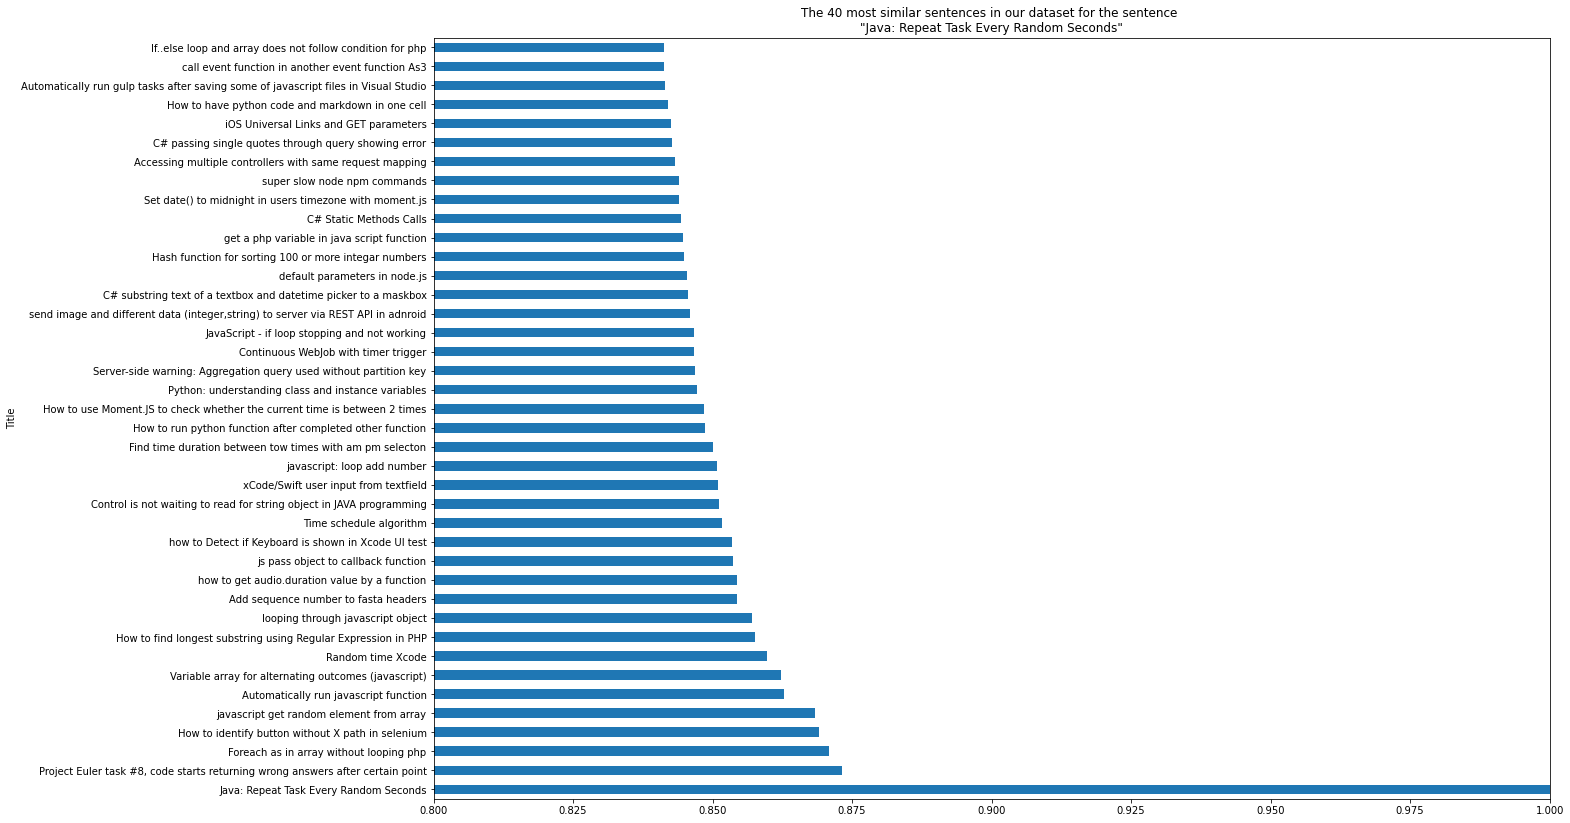

In [ ]:
def viz_sim_df_for_one_sent( sent_iloc=0, N = 40, sim_df_for_one_sent=sim_df_for_one_sent):
  # Plots the N most similar sentences in our dataframe for sentence at position sent_iloc
  sim_df_for_one_sent = get_sim_df_for_iloc(sent_iloc)
  
  sim_df_for_one_sent.index = sim_df_for_one_sent.Title
  sent = sim_df_for_one_sent.iloc[sent_iloc].Title
  ax = sim_df_for_one_sent.sort_values('sim_score', ascending = False).iloc[:N].sim_score.plot.barh(title=f'The {N} most similar sentences in our dataset for the sentence \n"{sent}"', figsize=(20,14))
  ax.set_xlim(0.8, 1)

# Just put in any number and get the plot for similarities of the sentence at df.iloc[i]
viz_sim_df_for_one_sent(0)

# 3.1  Calculate every similarity score between every sentence in the input dataframe pairwise and generate similarity matrix

In [ ]:
def get_sim_df_total( predictions,e_col, string_to_embed,pipe=pipe):
  # This function calculates the distances between every sentence pair. Creates for ever sentence a new column with the name equal to the sentence it comparse to 
  # put embeddings in matrix
  embed_mat = np.array([x for x in predictions[e_col]])
  # calculate distance between every embedding pair
  sim_mat = cosine_similarity(embed_mat,embed_mat)
  # for i,v in enumerate(sim_mat): predictions[str(i)+'_sim'] = sim_mat[i]
  for i,v in enumerate(sim_mat): 
    s = predictions.iloc[i].document
    predictions[s] = sim_mat[i]

  return predictions 

sim_matrix_df = get_sim_df_total(predictions,'sentence_embedding_bert', 'How to get started with Machine Learning and Python' )
sim_matrix_df

,document,sentence_embedding_bert,Java: Repeat Task Every Random Seconds,Why are Java Optionals immutable?,Text Overlay Image with Darkened Opacity React Native,Why ternary operator in swift is so picky?,hide/show fab with scale animation,Accessing pointer member of the structure using structure pointer,"How To Disable 2nd Saturday 4th Saturday ,Sunday And Holiday Date Using JQuery Calendar",Resizing containers in bootstrap,...,Is it possible to use the instance defined in managed C++ class in C#?,Auto Generate alphanumeric Unique Id with C# with sql server,insert into column data into new table,Add a security code to http get request,Error: unexpected '}',is it possible to use JavaScriptSpellCheck in jsp pages?,"Map<String, Integer> foo - how do I get the value of the integer - JAVA",Facebook SDK iOS - User photos doesn't retrieving in release build but works perfectly in Debug build.,Validate user input using seperate function,Get wikipedia city info - Java
0,Java: Repeat Task Every Random Seconds,"[-1.7254447937011719, -0.021515730768442154, 0...",1.000000,0.798323,0.701545,0.685166,0.767000,0.747972,0.695243,0.717713,...,0.767478,0.729963,0.756113,0.748378,0.677851,0.734841,0.755844,0.707948,0.797553,0.730619
1,Why are Java Optionals immutable?,"[-0.8677306175231934, -0.1372649371623993, -0....",0.798323,1.000000,0.702985,0.806698,0.700582,0.733434,0.683034,0.781085,...,0.810539,0.739156,0.789668,0.766723,0.676060,0.812024,0.791018,0.722101,0.770882,0.775782
2,Text Overlay Image with Darkened Opacity React...,"[-0.7461170554161072, -0.89825838804245, -0.27...",0.701545,0.702985,1.000000,0.702291,0.732625,0.751298,0.699528,0.695647,...,0.684786,0.760923,0.747968,0.685851,0.633427,0.718393,0.668317,0.715153,0.743547,0.645638
3,Why ternary operator in swift is so picky?,"[-1.0729691982269287, 0.11187640577554703, -0....",0.685166,0.806698,0.702291,1.000000,0.634143,0.699329,0.601452,0.673473,...,0.799892,0.680476,0.714787,0.699312,0.727117,0.741602,0.754326,0.654878,0.696009,0.616155
4,hide/show fab with scale animation,"[-0.5802487730979919, -0.2343166619539261, -0....",0.767000,0.700582,0.732625,0.634143,1.000000,0.682359,0.725059,0.768302,...,0.672759,0.722415,0.690678,0.648480,0.661772,0.708312,0.665353,0.788103,0.659952,0.741534
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,is it possible to use JavaScriptSpellCheck in ...,"[-0.2840780019760132, 0.913105309009552, 0.386...",0.734841,0.812024,0.718393,0.741602,0.708312,0.722319,0.668623,0.769583,...,0.785852,0.771577,0.785609,0.803988,0.639755,1.000000,0.790616,0.789588,0.746600,0.825154
4996,"Map<String, Integer> foo - how do I get the va...","[-0.6755825281143188, 0.02196516841650009, 0.1...",0.755844,0.791018,0.668317,0.754326,0.665353,0.771636,0.635473,0.674608,...,0.821192,0.796579,0.753467,0.748866,0.749535,0.790616,1.000000,0.755143,0.799140,0.750495
4997,Facebook SDK iOS - User photos doesn't retriev...,"[0.2970832586288452, 0.509556233882904, -0.359...",0.707948,0.722101,0.715153,0.654878,0.788103,0.728642,0.716646,0.758527,...,0.726627,0.797997,0.714537,0.781939,0.590529,0.789588,0.755143,1.000000,0.789295,0.723567
4998,Validate user input using seperate function,"[-0.6373348236083984, 0.4810838997364044, -0.5...",0.797553,0.770882,0.743547,0.696009,0.659952,0.828749,0.595842,0.714203,...,0.782001,0.834653,0.802570,0.808880,0.626128,0.746600,0.799140,0.789295,1.000000,0.675166


#3.2 Plot heatmap of similarity Matrix for the first N sentences

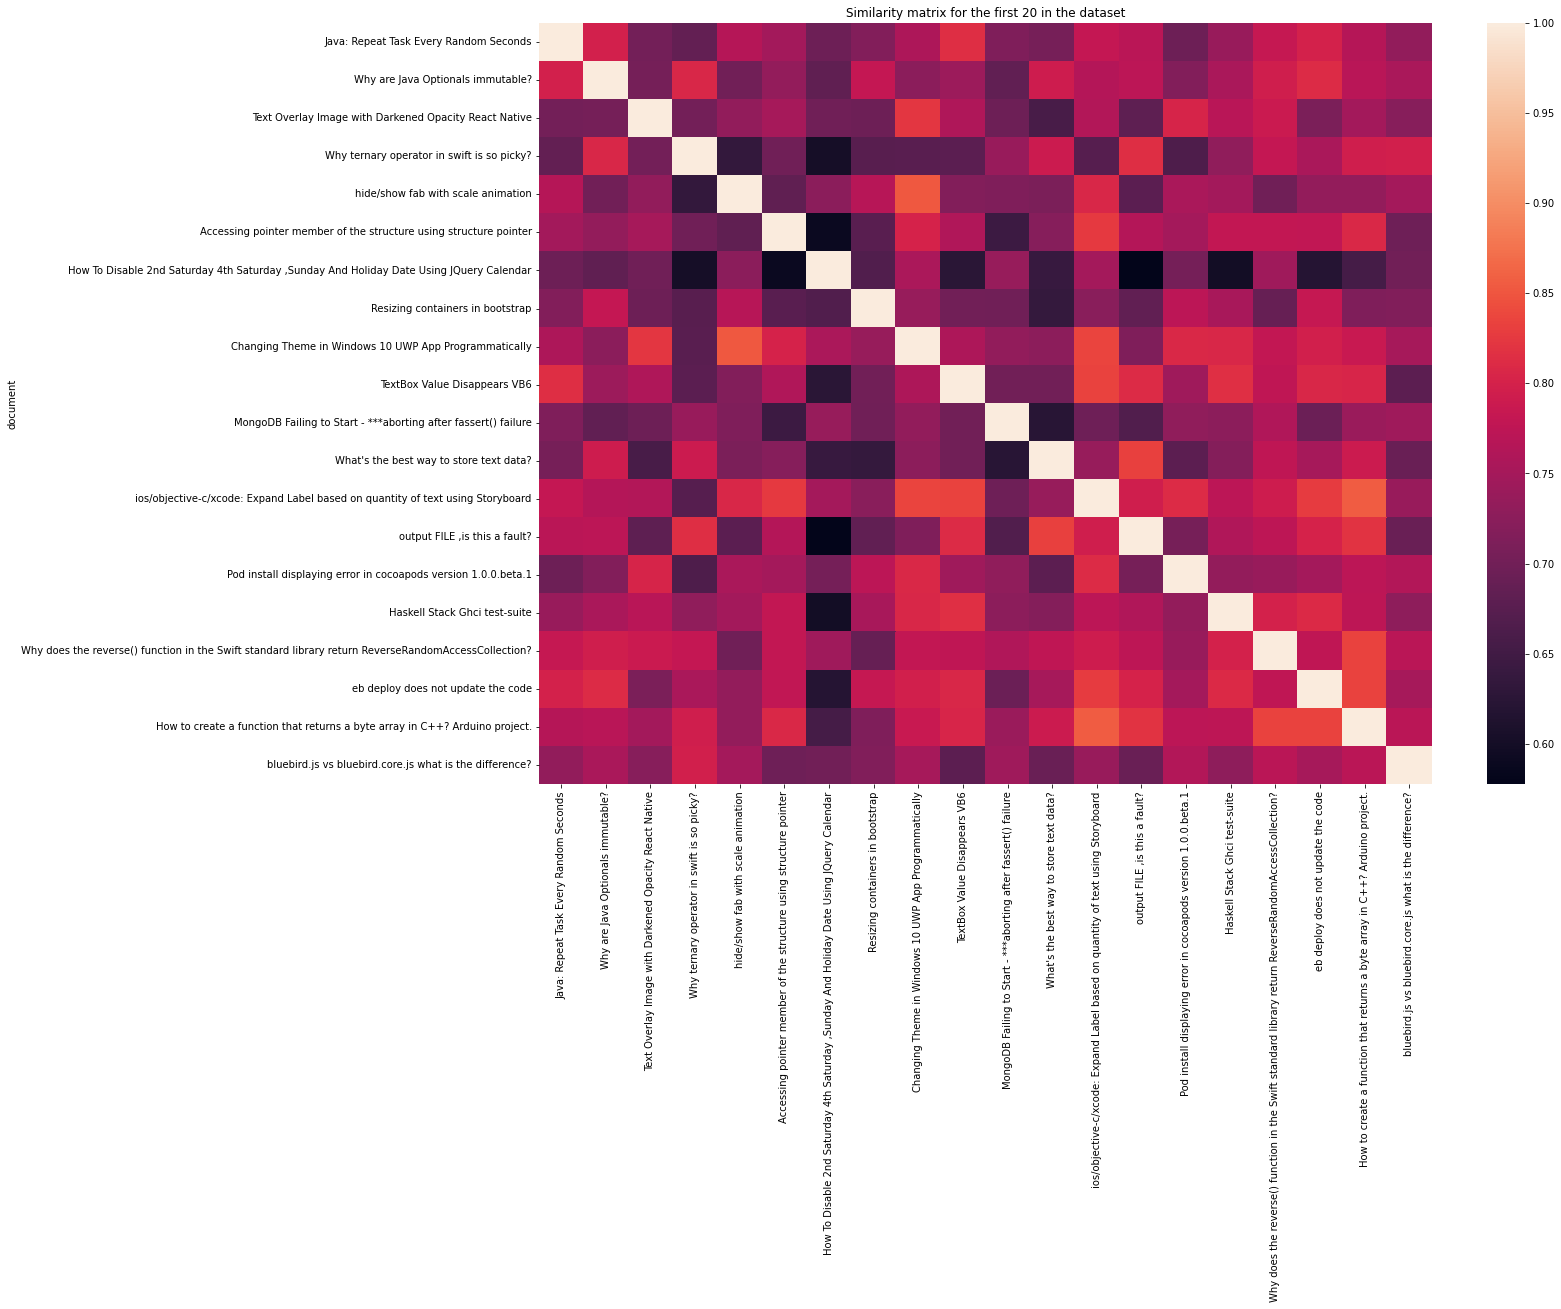

In [ ]:
non_sim_columns  = ['document','sentence_embedding_bert']

def viz_sim_matrix_first_n(num_sentences=20, sim_df = sim_matrix_df):
  # Plot heatmap for the first num_sentences
  fig, ax = plt.subplots(figsize=(20,14)) 
  sim_df.index = sim_df.document
  sim_columns = list(sim_df.columns)
  for b in non_sim_columns : sim_columns.remove(b)
  # sim_matrix_df[sim_columns]
  ax = sns.heatmap(sim_df.iloc[:num_sentences][sim_columns[:num_sentences]]) 

  ax.axes.set_title(f"Similarity matrix for the first {num_sentences} in the dataset",)

viz_sim_matrix_first_n()

#3.3 Plot heatmap of similarity Matrix for the sentences between starT_iloc and end_iloc 

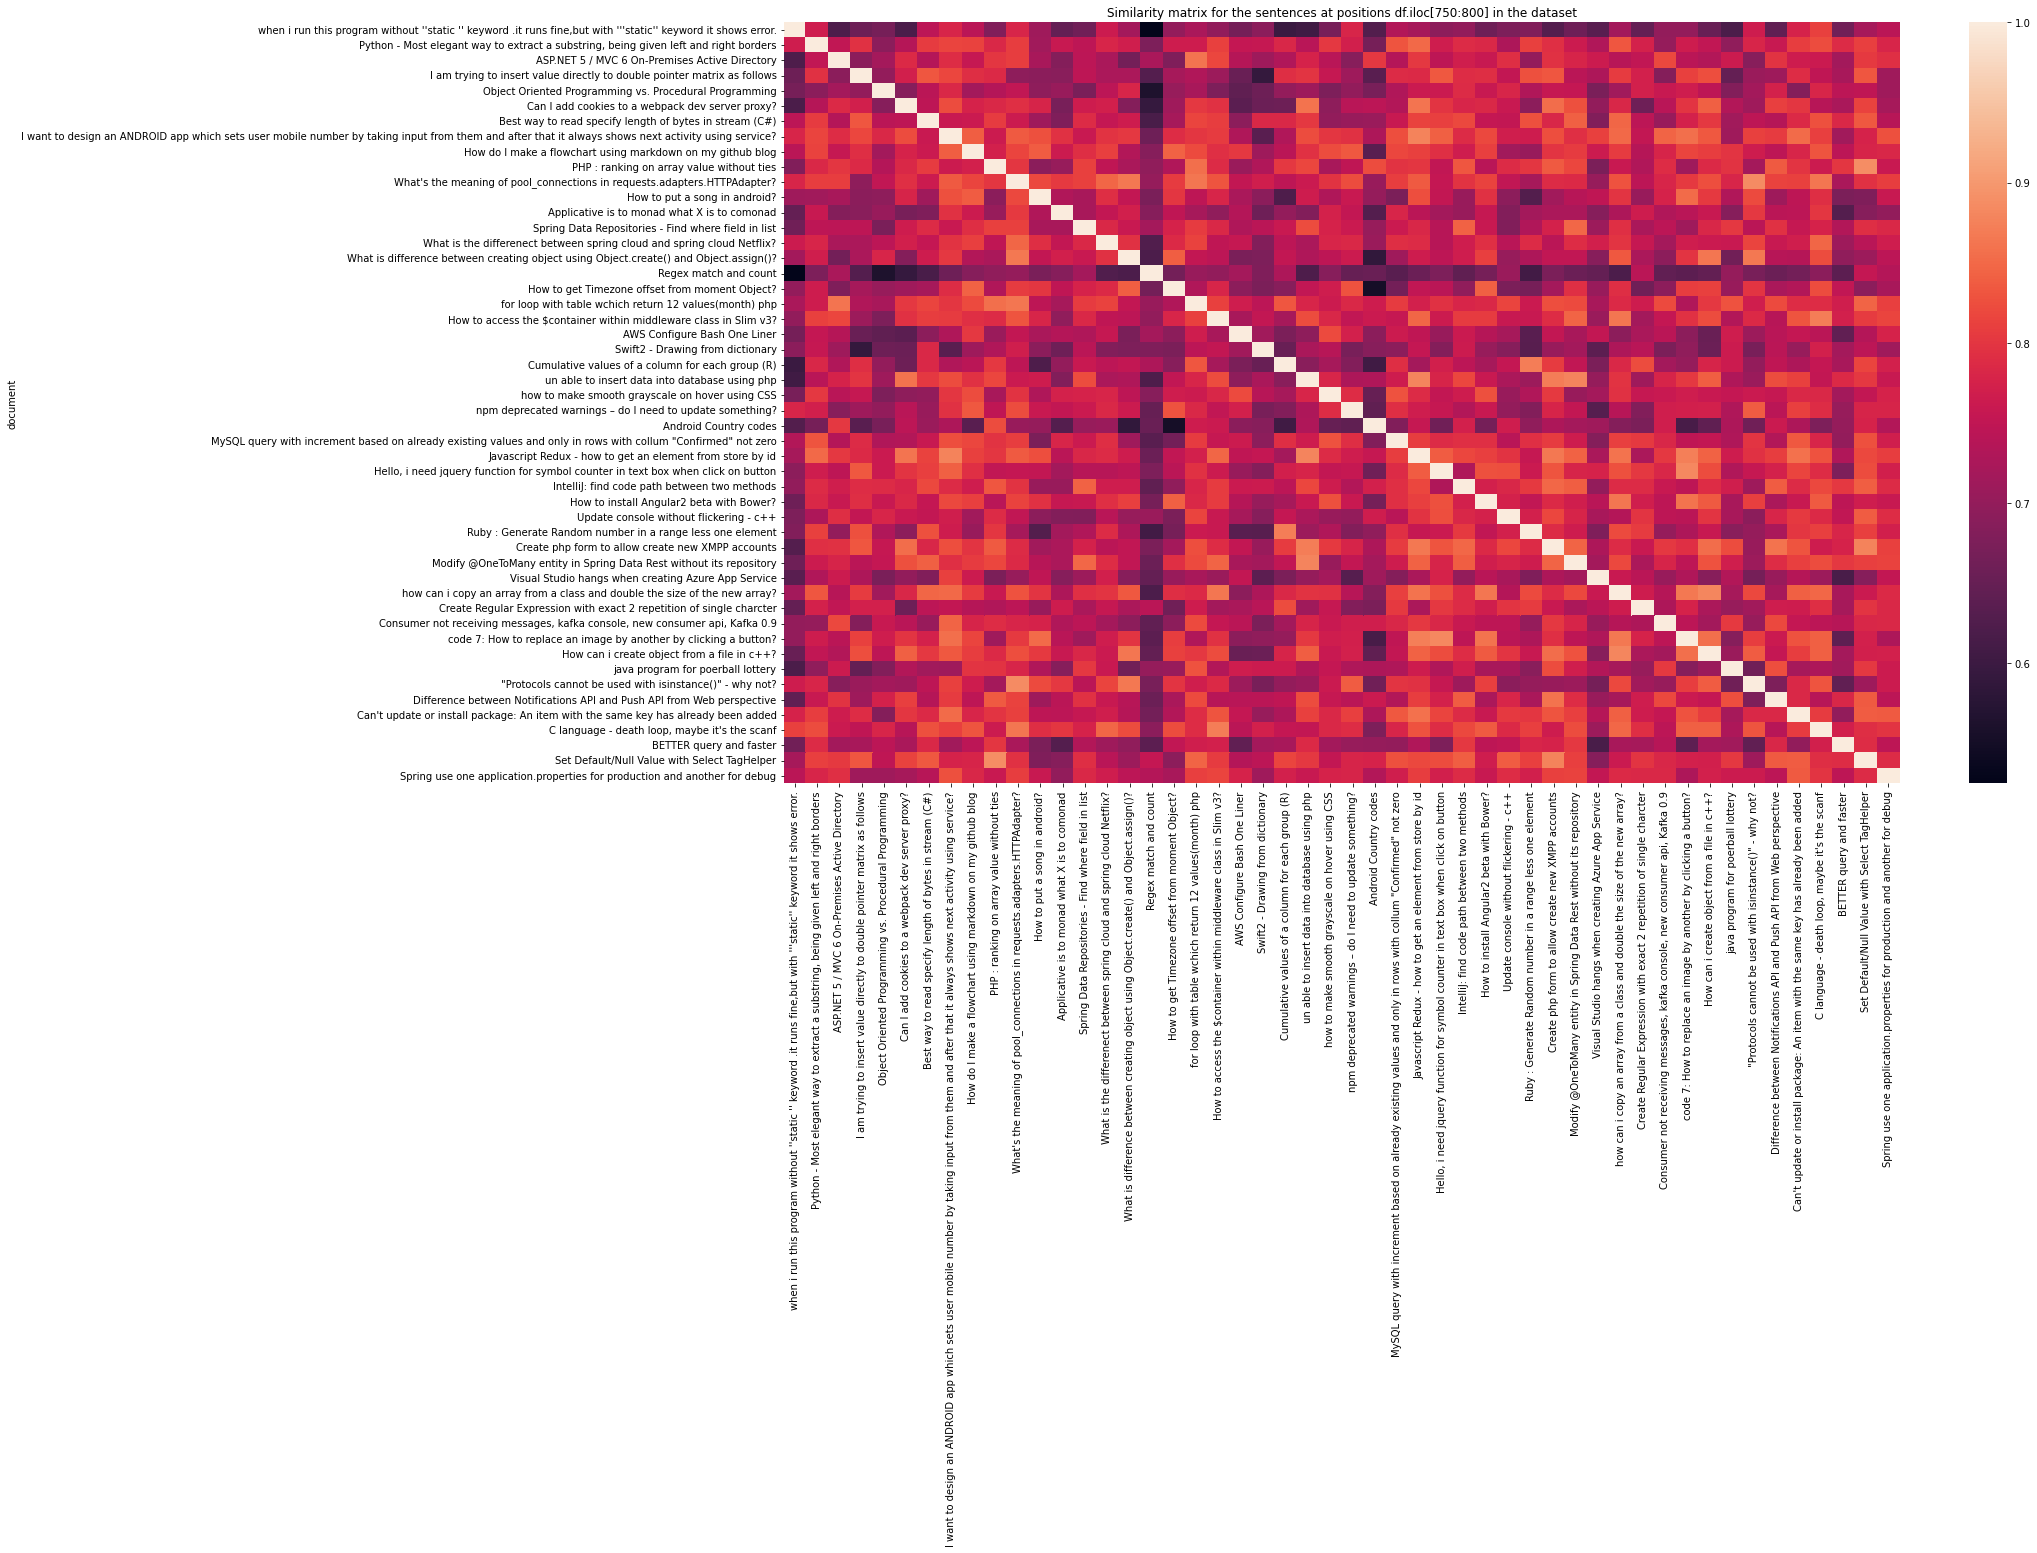

In [ ]:
def viz_sim_matrix_from_to(start_iloc,end_iloc, sim_df = sim_matrix_df):
  # Plot heatmatrix for sentences at df.iloc[start:end]   
  fig, ax = plt.subplots(figsize=(25,14)) 
  sim_df.index = sim_df.document
  sim_columns = list(sim_df.columns)
  for b in non_sim_columns : sim_columns.remove(b)


  ax = sns.heatmap(sim_df.iloc[start_iloc:end_iloc][sim_columns[start_iloc:end_iloc]]) # +2 because first 2 cols are not sim_scores

  ax.axes.set_title(f"Similarity matrix for the sentences at positions df.iloc[{start_iloc}:{end_iloc}] in the dataset",)

viz_sim_matrix_from_to(750,800)

#4.1 Find the N most similar sentences in a datset for a **new sentence** that does not exist in the data using BERT

In [ ]:
def get_sim_df_for_string(predictions,e_col, string_to_embed,pipe=pipe):
  # Creates a Dataframe which has a sim_score column which describes the similarity with the string_to_embed variable

  # put predictions vectors in matrix
  embed_mat = np.array([x for x in predictions[e_col]])

  # embed string input string
  embedding = pipe.predict(string_to_embed).iloc[0][e_col]

  # Replicate embedding for input string 
  m = np.array([embedding,]*len(df))
  sim_mat = cosine_similarity(m,embed_mat)

  #write sim score
  df['sim_score'] = sim_mat[0]


  return df

sentence_detector_dl download started this may take some time.
Approximate size to download 354.6 KB
[OK!]


(0.8, 1.0)

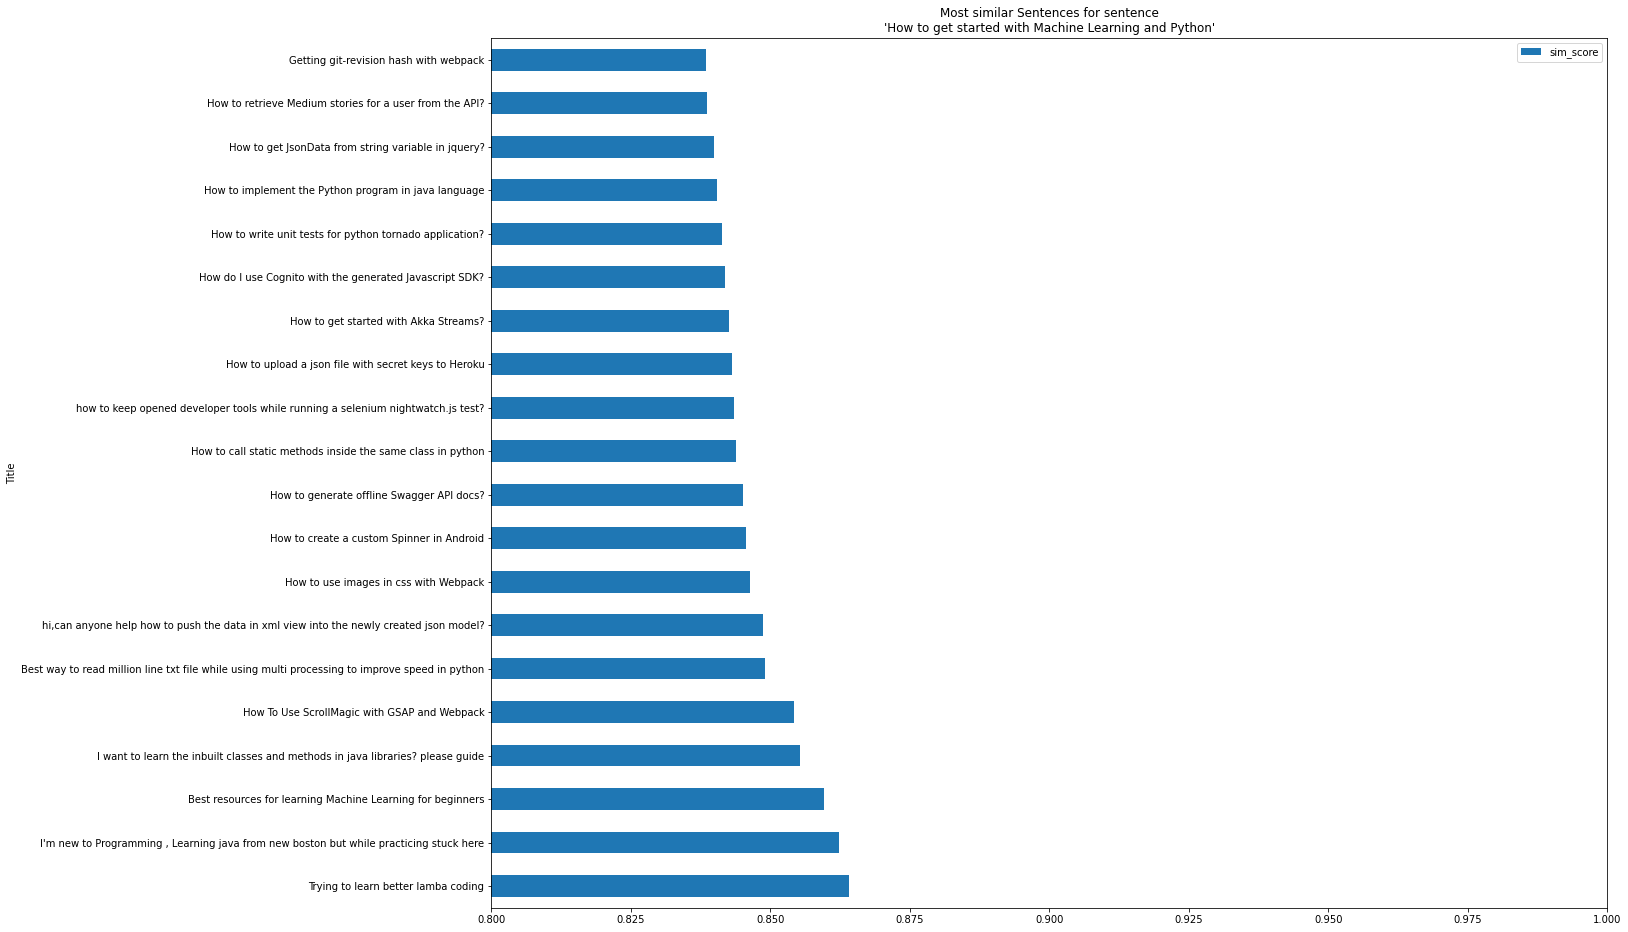

In [ ]:
question = 'How to get started with Machine Learning and Python' 
sim_df = get_sim_df_for_string(predictions,'sentence_embedding_bert', 'How to get started with Machine Learning and Python' )
ax = sim_df.sort_values('sim_score', ascending = False).iloc[:20][['sim_score','Title']].plot.barh(title = f"Most similar Sentences for sentence\n'{question}'", figsize=(20,16))
ax.set_xlim(0.8, 1)


#4.2 Define Helper plotting function to plot results of embedding a string

In [ ]:
def viz_sim_df_for_one_sent( question='How to install linux dualboot', e_col='sentence_embedding_bert', N = 40, sim_df_for_one_sent=sim_df_for_one_sent):
  # Plots the N most similar sentences in our dataframe for sentence at position sent_iloc
  sim_df = get_sim_df_for_string(predictions,e_col,question )
  sim_df.index = sim_df.Title
  sim_df.sort_values('sim_score', ascending = False).iloc[:N][['sim_score','Title']].plot.barh(title = f"Most similar Sentences for sentence\n'{question}'", figsize=(20,14))
  ax.set_xlim(0.8, 1)


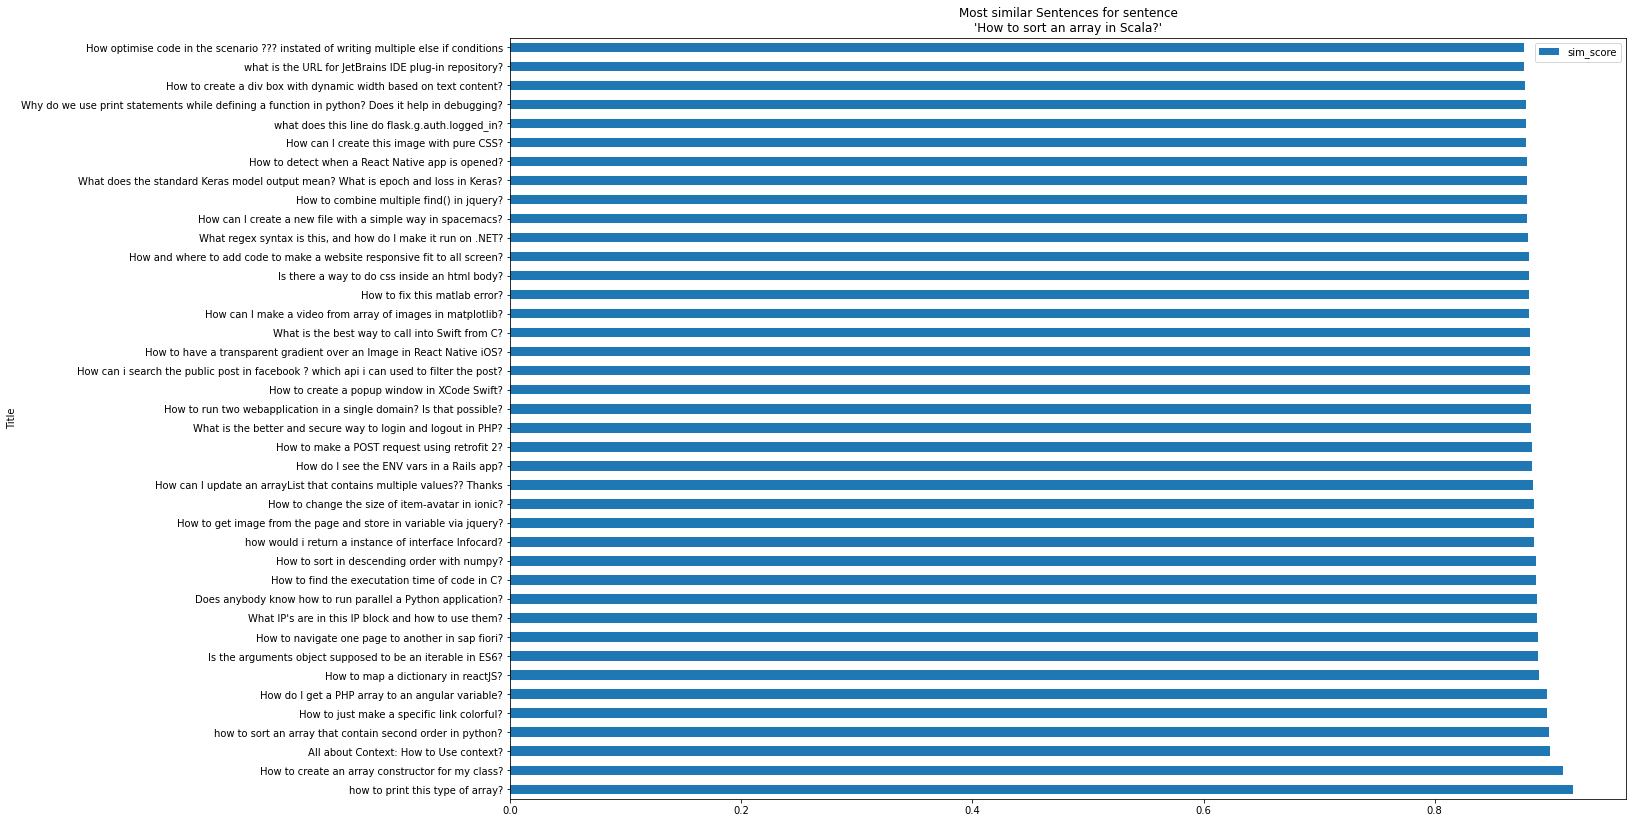

In [ ]:
question = 'How to sort an array in Scala?'
e_col = 'sentence_embedding_bert'
viz_sim_df_for_one_sent(question,e_col)

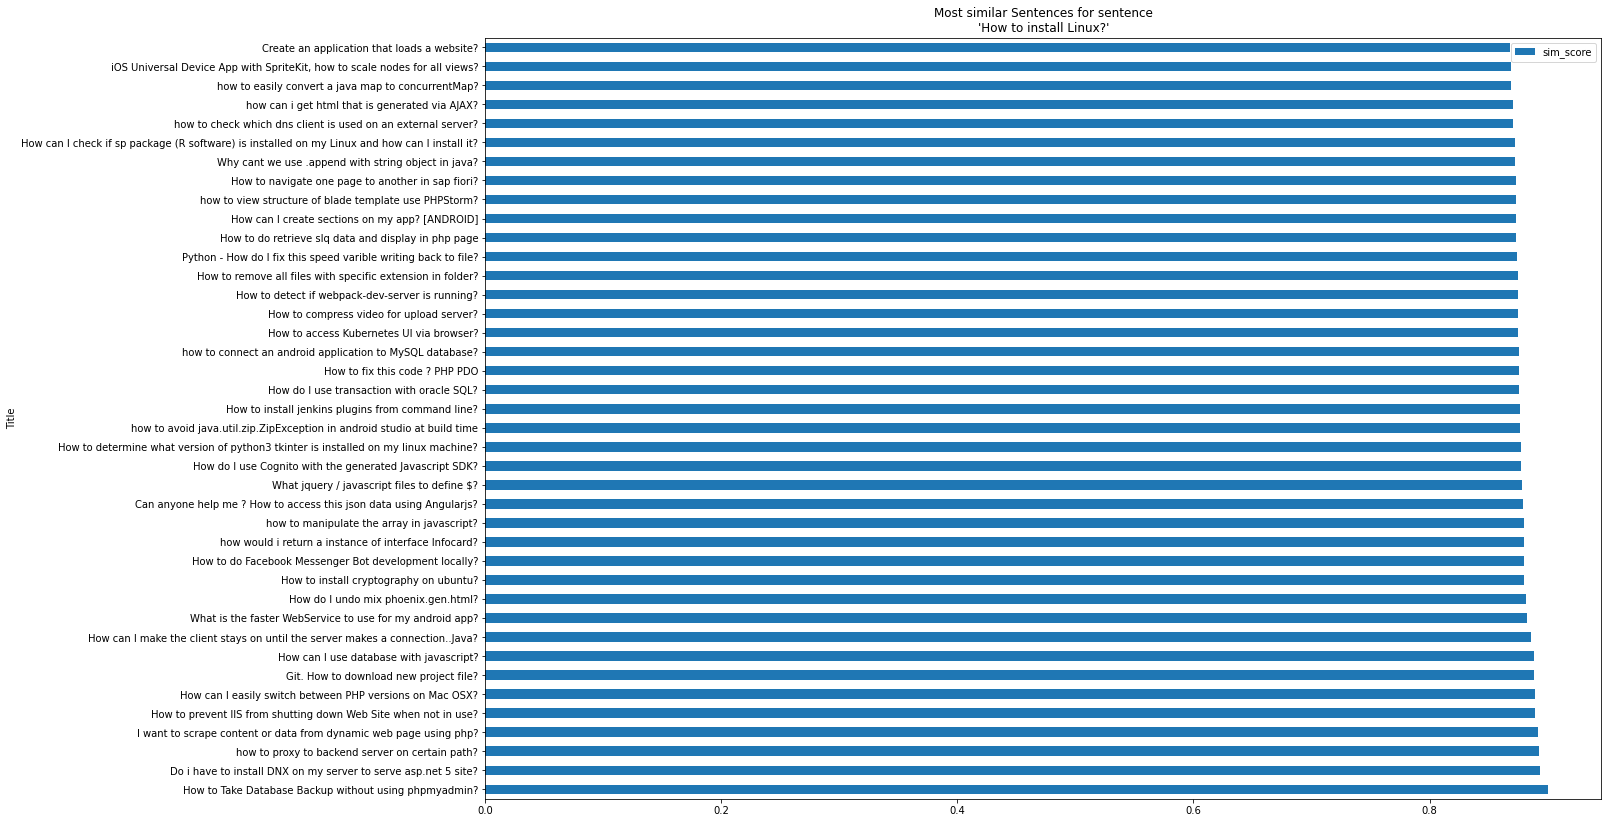

In [ ]:
viz_sim_df_for_one_sent('How to install Linux?')

# 5.1. Multi Embedding Similarity, find the N most similar sentences in a dataset for a new sentence using BERT, USE, Electra

First, let's load 3 embeddings at the same time and embed the text in our dataset

In [ ]:
multi_pipe = nlu.load('use en.embed_sentence.electra embed_sentence.bert')
multi_embeddings = multi_pipe.predict(df.Title,output_level='document')
# multi_embeddings = multi_pipe.predict(df.Title)

multi_embeddings


tfhub_use download started this may take some time.
Approximate size to download 923.7 MB
[OK!]
sent_electra_small_uncased download started this may take some time.
Approximate size to download 48.7 MB
[OK!]
sent_small_bert_L2_128 download started this may take some time.
Approximate size to download 16.1 MB
[OK!]


,document,sentence_embedding_bert,sentence_embedding_electra,sentence_embedding_use
0,Java: Repeat Task Every Random Seconds,"[-1.7254447937011719, -0.021515730768442154, 0...","[0.5497088432312012, 0.3958696126937866, 0.139...","[-0.05815371498465538, 0.016799110919237137, -..."
1,Why are Java Optionals immutable?,"[-0.8677306175231934, -0.1372649371623993, -0....","[0.30329322814941406, -0.04580698162317276, -0...","[-0.00033905860618688166, -0.04124700278043747..."
2,Text Overlay Image with Darkened Opacity React...,"[-0.7461170554161072, -0.89825838804245, -0.27...","[0.07242833822965622, 0.07733730226755142, 0.1...","[0.02146691083908081, -0.06822465360164642, -0..."
3,Why ternary operator in swift is so picky?,"[-1.0729691982269287, 0.11187640577554703, -0....","[0.14620625972747803, 0.09563517570495605, -0....","[0.04972146451473236, 0.035496875643730164, -0..."
4,hide/show fab with scale animation,"[-0.5802487730979919, -0.2343166619539261, -0....","[0.15455277264118195, 0.284525990486145, 0.023...","[-0.0456671379506588, -0.04558160528540611, -0..."
...,...,...,...,...
4995,is it possible to use JavaScriptSpellCheck in ...,"[-0.2840780019760132, 0.913105309009552, 0.386...","[0.35000815987586975, 0.15856197476387024, 0.0...","[0.062474653124809265, -0.032156772911548615, ..."
4996,"Map<String, Integer> foo - how do I get the va...","[-0.6755825281143188, 0.02196516841650009, 0.1...","[0.09118041396141052, 0.029952362179756165, 0....","[0.017181310802698135, -0.012151309289038181, ..."
4997,Facebook SDK iOS - User photos doesn't retriev...,"[0.2970832586288452, 0.509556233882904, -0.359...","[-0.20104309916496277, -0.10363496840000153, 0...","[0.056753773242235184, -0.047539979219436646, ..."
4998,Validate user input using seperate function,"[-0.6373348236083984, 0.4810838997364044, -0.5...","[0.4792034327983856, 0.3143695890903473, 0.192...","[0.04016668349504471, -0.01402831170707941, -0..."


#5.2 Multi Embeddings Similarity calculation


Let's define a function that takes in a string to embed, a list of embeddings and a pipeline

get_sim_df_for_string_multi() calculates all embeddings loaded in the input NLU pipeline for the input string and calculate distances to every sentence in the input DF across all embeddings and will give us a final normalized score.     

In [ ]:
def get_sim_df_for_string_multi(predictions,embed_col_names, string_to_embed,pipe=multi_pipe):
  # Creates a Dataframe which has a sim_score column which describes the similarity with the string_to_embed variable
  # This accumulates the distances of all embeddings in embed_col_names and normalizes it by dividing by len(embed_col_names)
  #make empty simmilarity matrix which will store the aggregated simmilarities between different embeddings
  predictions.dropna(inplace=True)
  cum_sim = np.zeros((len(predictions),len(predictions)))

  # embed with all embedders currently loaded in pipeline
  embeddings = pipe.predict(string_to_embed).iloc[0]

  #loop over all embeddings columns and accumulate the pairwise distances with string_to_embed into cum_sim
  for e_col in embed_col_names:
    # get the current embedding for input string
    embedding = embeddings[e_col]  
    # stack embedding vector for input string
    m = np.array([embedding,]*len(predictions)) 
    # put df vectors in np matrix
    embed_mat = np.array([x for x in predictions[e_col]]) 
    # calculate new similarities
    sim_mat = cosine_similarity(m,embed_mat) 
  # accumulate new simmilarities in cum_sum
    cum_sim += sim_mat  

  predictions['sim_score'] = cum_sim[0]/len(embed_col_names) 
  return predictions

sentence_detector_dl download started this may take some time.
Approximate size to download 354.6 KB
[OK!]


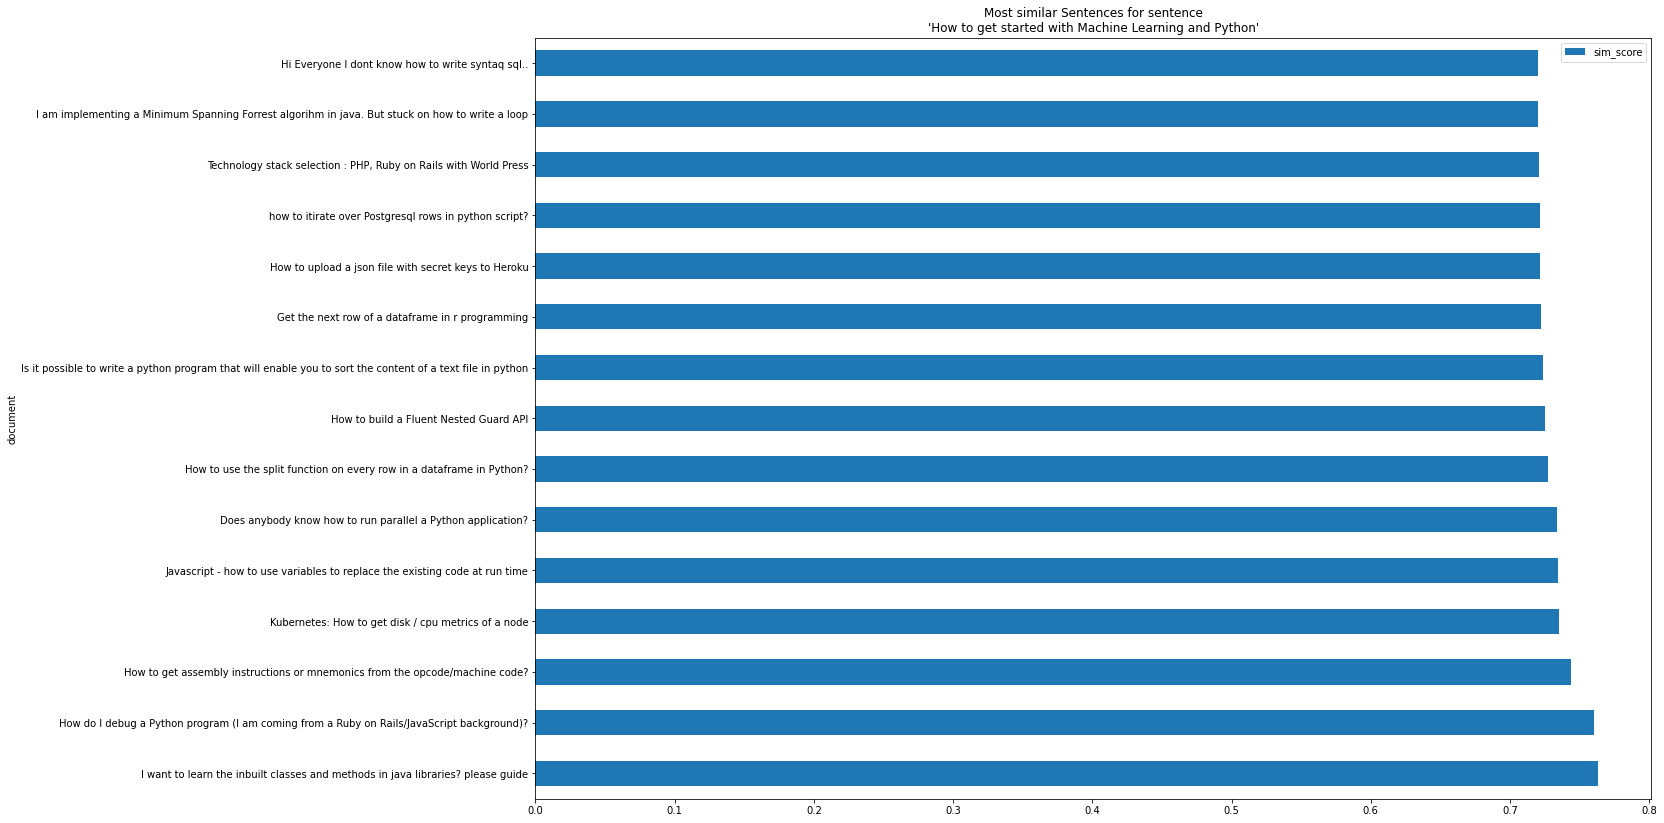

In [ ]:
question = 'How to get started with Machine Learning and Python'
col_names = ['sentence_embedding_use','sentence_embedding_electra', 'sentence_embedding_bert']

sim_df = get_sim_df_for_string_multi(multi_embeddings,col_names, question )
sim_df.index = sim_df.document
sim_df.sort_values('sim_score', ascending = False).iloc[:15][['sim_score','document']].plot.barh(title = f"Most similar Sentences for sentence\n'{question}'", figsize=(20,14))

# 5.3 Define helper function to plot the similarity results of a multi embedded string

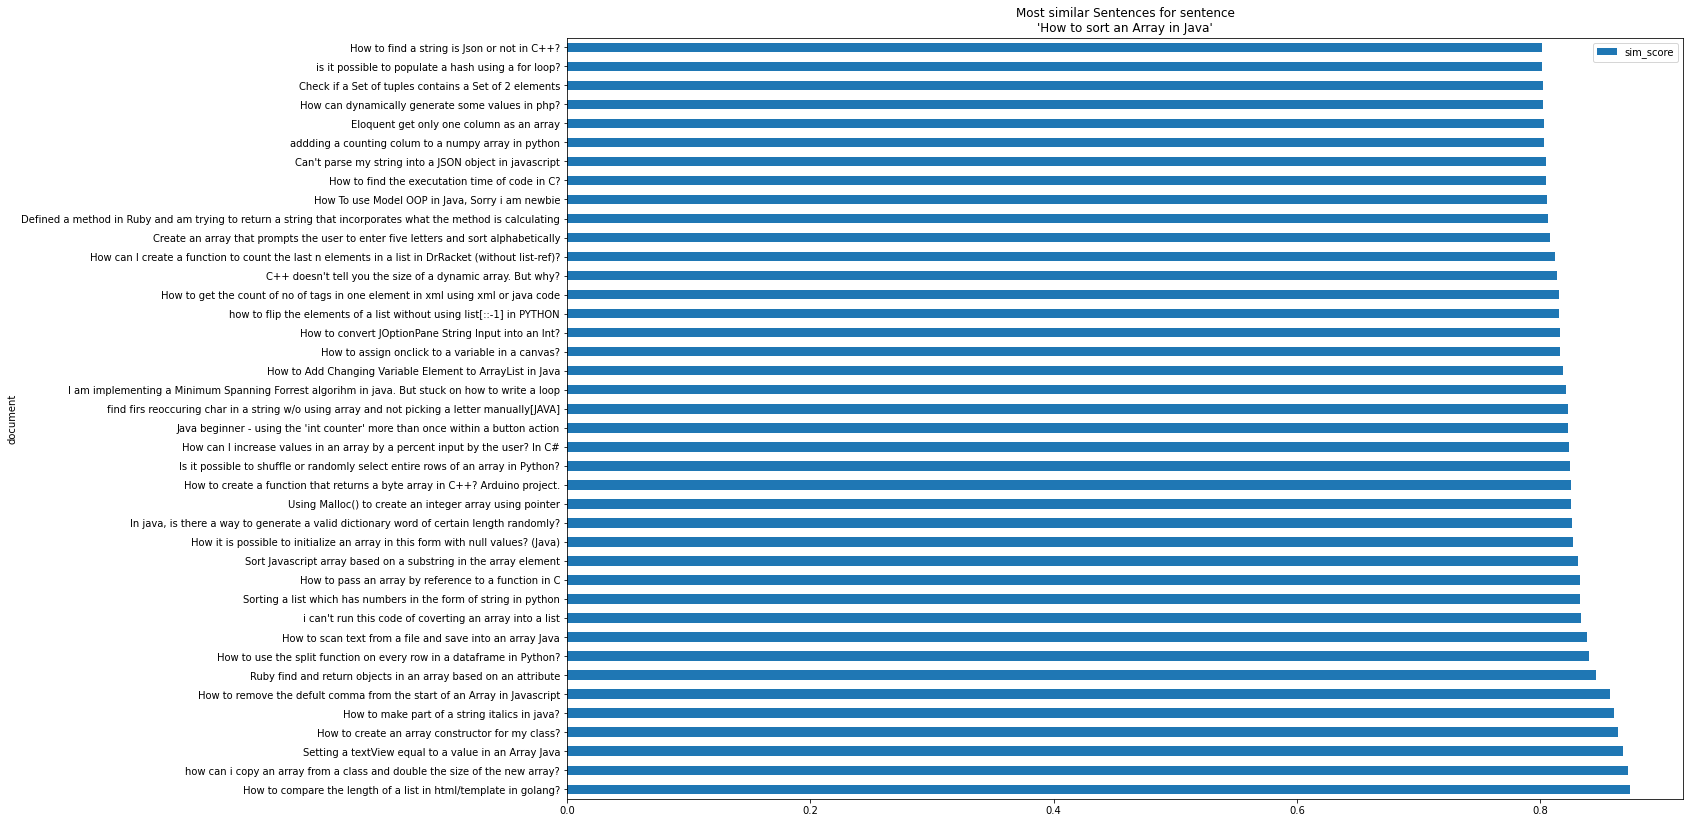

In [ ]:
def viz_sim_df_for_one_sent_multi_embed( question='How to install linux dualboot', e_cols=col_names, N = 40, multi_embeddings=multi_embeddings):
  # Plots the N most similar sentences in our dataframe for sentence at position sent_iloc
  sim_df = get_sim_df_for_string_multi(multi_embeddings,col_names, question )
  sim_df.index = sim_df.document
  sim_df.sort_values('sim_score', ascending = False).iloc[:N][['sim_score','document']].plot.barh(title = f"Most similar Sentences for sentence\n'{question}'",figsize=(20,14))

  ax.set_xlim(0.8, 1)

question = 'How to sort an Array in Java'
col_names = ['sentence_embedding_use','sentence_embedding_electra', 'sentence_embedding_bert']
viz_sim_df_for_one_sent_multi_embed(question, col_names)

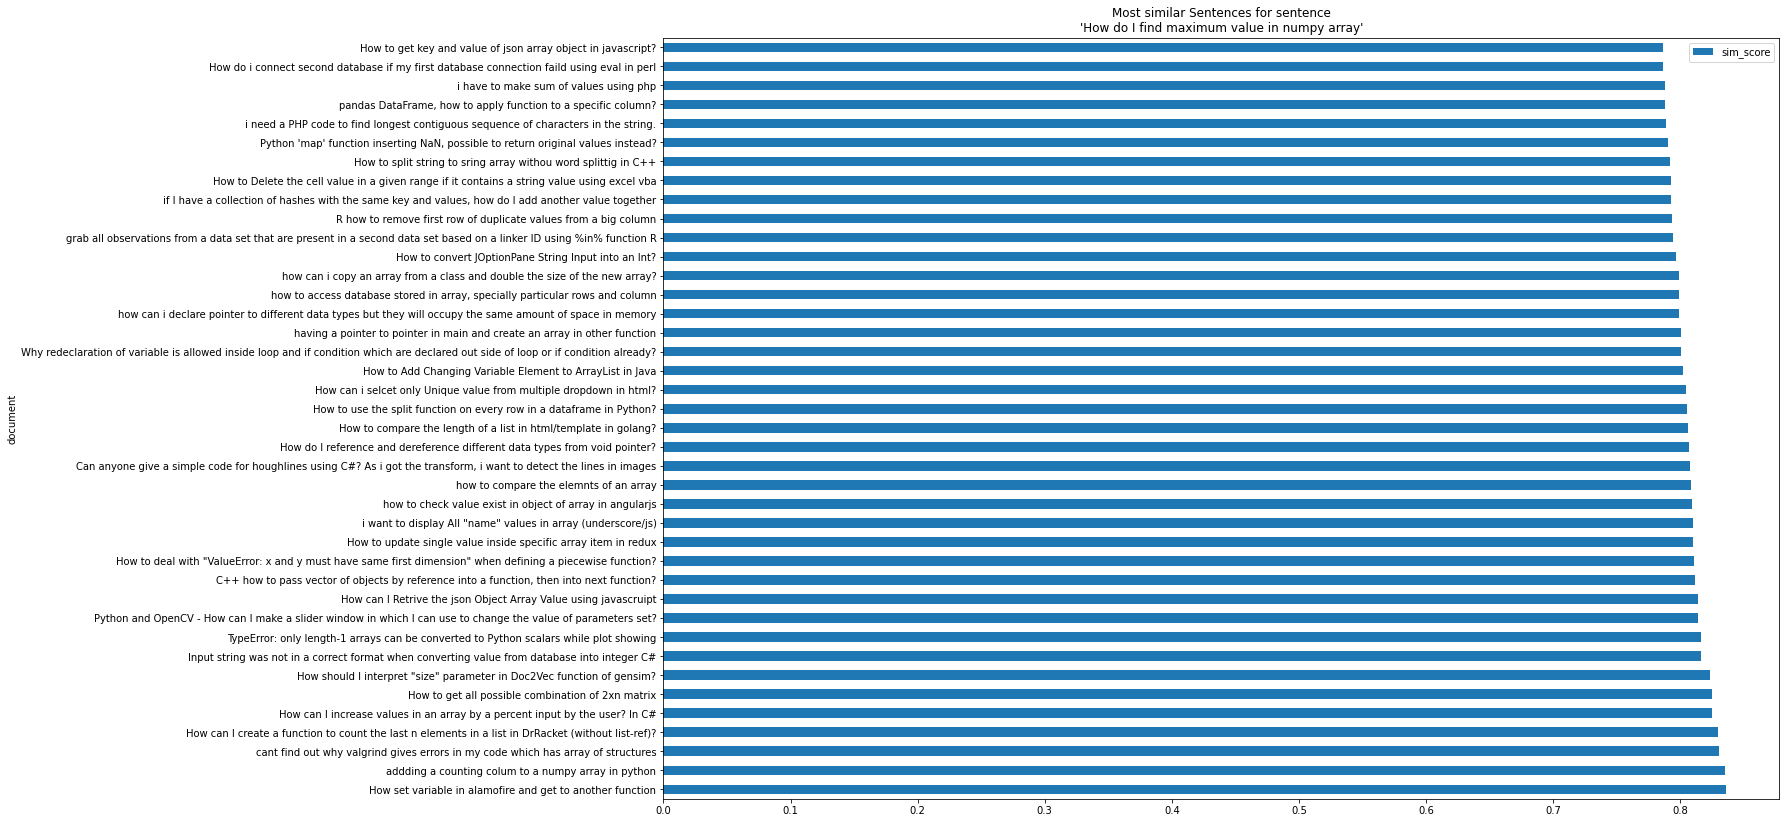

In [ ]:
question = 'How do I find maximum value in numpy array'
viz_sim_df_for_one_sent_multi_embed(question)

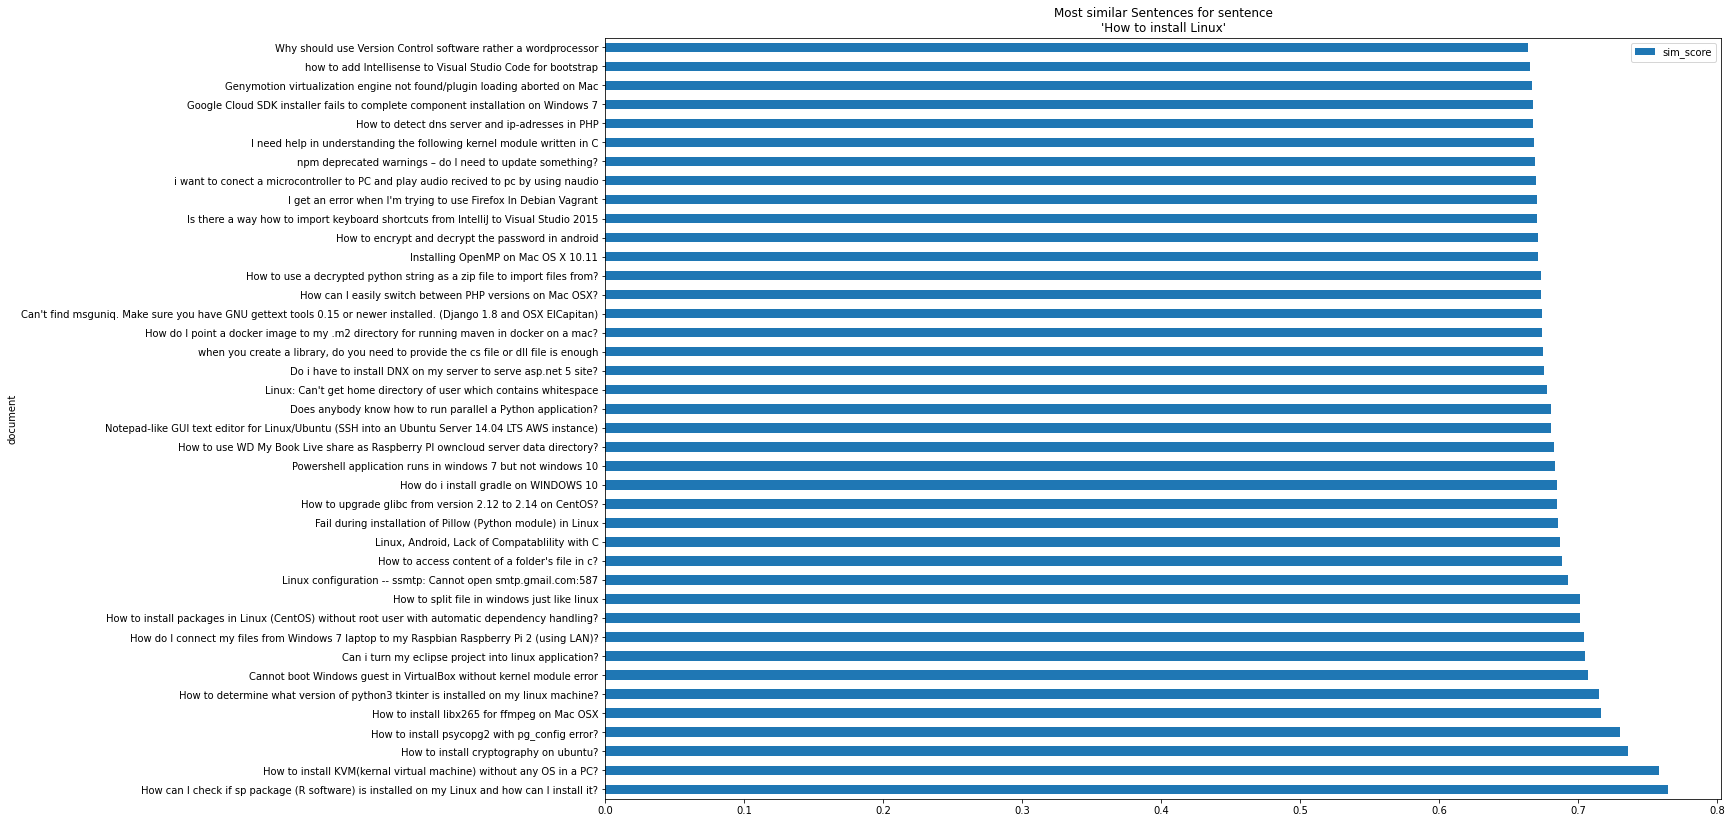

In [ ]:
question = 'How to install Linux'
viz_sim_df_for_one_sent_multi_embed(question)

# 6. There are many more Sentence Embeddings to try out!
Even multi lingual embeddings like nlu.load('xx.embed_sentence.labse')

In [ ]:
nlu.print_all_model_kinds_for_action('embed_sentence')

For language <nl> NLU provides the following Models : 
nlu.load('nl.embed_sentence.bert.base_cased') returns Spark NLP model sent_bert_base_cased
For language <en> NLU provides the following Models : 
nlu.load('en.embed_sentence.bert_use_cmlm_en_base') returns Spark NLP model sent_bert_use_cmlm_en_base
nlu.load('en.embed_sentence.bert_use_cmlm_en_large') returns Spark NLP model sent_bert_use_cmlm_en_large
nlu.load('en.embed_sentence') returns Spark NLP model tfhub_use
nlu.load('en.embed_sentence.use') returns Spark NLP model tfhub_use
nlu.load('en.embed_sentence.tfhub_use') returns Spark NLP model tfhub_use
nlu.load('en.embed_sentence.use.lg') returns Spark NLP model tfhub_use_lg
nlu.load('en.embed_sentence.tfhub_use.lg') returns Spark NLP model tfhub_use_lg
nlu.load('en.embed_sentence.albert') returns Spark NLP model albert_base_uncased
nlu.load('en.embed_sentence.electra') returns Spark NLP model sent_electra_small_uncased
nlu.load('en.embed_sentence.electra_small_uncased') returns S